### start

In [91]:
# pyright: reportMissingImports=false
# pyright: reportMissingModuleSource=false

import uuid
import random
import hashlib
import os
import sys
import gc
import time
import copy
import logging
import re
from itertools import chain,combinations
import pdb
import math
from pathlib import Path
import datetime
from datetime import datetime,timedelta
import json
import warnings
import yaml
from typing import Dict,Union,List,Any,Tuple
import pytest
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import IPython
import requests
import warnings
import boto3
import matplotlib as plt
import sklearn

# load_dotenv(Path("../../../Local/.env"))

# Custom format function for displaying |numbers/
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')

# Suppress warnings
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings('ignore', message='.*frozen modules.*')
warnings.filterwarnings("ignore", message="MallocStackLogging")

# silence pygame donation request
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"
os.environ['LOGGING_FILE'] = "../../../Local/logs/wallet_modeling.log"
os.environ['NOTIFICATION_SOUNDS_DIR'] = "../../../Local"

# Dark mode charts
plt.rcParams['figure.facecolor'] = '#181818'  # Custom background color (dark gray in this case)
plt.rcParams['axes.facecolor'] = '#181818'
plt.rcParams['text.color'] = '#afc6ba'
plt.rcParams['axes.labelcolor'] = '#afc6ba'
plt.rcParams['xtick.color'] = '#afc6ba'
plt.rcParams['ytick.color'] = '#afc6ba'
plt.rcParams['axes.titlecolor'] = '#afc6ba'
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'

# import local modules
# pyright: reportMissingImports=false
sys.path.append('../src')

import sage_utils.config_validation as ucv
import sage_utils.s3_utils as s3u

import sage_wallet_insights.model_evaluation as sime

import sage_wallet_modeling.wallet_modeler as wm
from sage_wallet_modeling.wallet_preprocessor import SageWalletsPreprocessor
import sage_wallet_modeling.wallet_script_modeler as sm
import sage_wallet_modeling.workflow_orchestrator as wo

import script_modeling.entry_helpers as h
# import script_modeling.temporal_cv_model_entry as tme


# import data-science modules
sys.path.append(str(Path("..") / ".." / "data-science" / "src"))
import wallet_insights.model_evaluation as wime
import utils as u
from utils import ConfigError



# reload all modules
modules = [
    ucv, s3u,
    sime,
    wm, sm, wo,
    h,
    wime,
    u,
]

# import utils as u
# Set the custom error handler
ipython = IPython.get_ipython()
# ipython.set_custom_exc((Exception,), u.notify_on_failure)

player = u.AmbientPlayer()
player.stop_all_players()

# configure logger
logger = u.setup_notebook_logger('../logs/notebook_logs.log')
logger.setLevel(logging.INFO)

from IPython.core import ultratb
ultratb.VerboseTB._tb_highlight = "bg:#b45827"


# load all configs
sage_wallets_config = ucv.load_sage_wallets_config(Path('../config/sage_wallets_config.yaml'))
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config(Path('../config/sage_wallets_modeling_config.yaml'))


u.export_code(
    code_directories=[
        # 'config_models',
        'sage_wallet_insights',
        'sage_wallet_modeling',
        'script_modeling',
        # 'sage_utils',
    ],
    # include_config = True,
    # ipynb_notebook = 'DDA-769 coin model score dist toggle.ipynb'
    output_file="temp/sagemaker_code.py"
)

[importlib.reload(module) for module in modules]
u.notify('retro')

logger.milestone("Good morning, let's get to work")

[06/Aug/25 22:23:19] INFO [utils.export_code:1672] Consolidation complete. All files are saved in temp/sagemaker_code.py
[06/Aug/25 22:23:20] MILESTONE [2505902246.<module>:136] Good morning, let's get to work


# Model Training

## Concatenated Model Sequence

In [94]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.load_all_training_data()

[06/Aug/25 22:23:36] INFO [workflow_orchestrator.load_all_training_data:119] Auto-detected date_suffixes from config: ['221212', '230111', '230210', '230312', '230411', '230511', '230610', '230710', '230908', '231107', '240106', '240306', '230809', '231008', '231207', '240205', '240405', '240505', '240604', '240704', '240803', '240902']
[06/Aug/25 22:23:36] MILESTONE [workflow_orchestrator.load_all_training_data:139] <DEV> Loading training data for 22 periods: ['221212', '230111', '230210', '230312', '230411', '230511', '230610', '230710', '230908', '231107', '240106', '240306', '230809', '231008', '231207', '240205', '240405', '240505', '240604', '240704', '240803', '240902']
[06/Aug/25 22:23:37] INFO [workflow_orchestrator.load_all_training_data:155] Training data loaded successfully: 167,776 total rows and 1 offsets for each date_suffix.


#### preprocess and concatenate

In [97]:
workflow_orch.concatenate_all_preprocessed_data(repreprocess_offsets=True)
# workflow_orch.concatenate_all_preprocessed_data(repreprocess_offsets=False)

[06/Aug/25 22:24:58] INFO [workflow_orchestrator.preprocess_all_training_data:177] Preprocessing 22 date periods...
[06/Aug/25 22:24:59] INFO [wallet_preprocessor.preprocess_training_data:77] Starting preprocessing for SageMaker XGBoost compatibility...
[06/Aug/25 22:24:59] INFO [wallet_preprocessor._handle_missing_values:241] Filled NaN values in 102 columns for x_train.
[06/Aug/25 22:24:59] INFO [wallet_preprocessor._save_preprocessed_df:362] Saved preprocessed train split to ../s3_uploads/wallet_training_data_preprocessed/dda_947_x_in_cont_dev/221212/train.csv
[06/Aug/25 22:24:59] INFO [wallet_preprocessor._save_preprocessed_df:362] Saved preprocessed train_y split to ../s3_uploads/wallet_training_data_preprocessed/dda_947_x_in_cont_dev/221212/train_y.csv
[06/Aug/25 22:24:59] INFO [wallet_preprocessor.preprocess_training_data:123] Preprocessed train: 1,000 rows × 230 cols.
[06/Aug/25 22:24:59] INFO [wallet_preprocessor._handle_missing_values:241] Filled NaN values in 102 columns for

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 workflow_orch.concatenate_all_preprocessed_data(repreprocess_offsets=True)                   │
│   2 # workflow_orch.concatenate_all_preprocessed_data(repreprocess_offsets=False)                │
│   3                                                                                              │
│                                                                                                  │
│ /Users/jeremymeadow/DreamsData/GitHub/sagemaker/notebooks/../src/utils.py:548 in wrapper         │
│                                                                                                  │
│    545 │   │   │   logger.debug('Initiating %s...', func.__name__)                               │
│    546 │   │   │                                                                                 │
│    547 │   │   │   start_time = time.time()                                                      │
│ ❱  548 │   │   │   result = func(*args, **kwargs)                                                │
│    549 │   │   │   duration = time.time() - start_time                                           │
│    550 │   │   │                                                                                 │
│    551 │   │   │   if duration >= 60:                                                            │
│                                                                                                  │
│ /Users/jeremymeadow/DreamsData/GitHub/sagemaker/notebooks/../src/sage_wallet_modeling/workflow_o │
│ rchestrator.py:265 in concatenate_all_preprocessed_data                                          │
│                                                                                                  │
│    262 │   │   │   │   continue                                                                  │
│    263 │   │   │                                                                                 │
│    264 │   │   │   # Validate no NaNs before saving                                              │
│ ❱  265 │   │   │   if concatenated.isnull().any().any():                                         │
│    266 │   │   │   │   raise ValueError(f"NaN values detected in {split} split before saving to  │
│    267 │   │   │                                                                                 │
│    268 │   │   │   concatenated = pd.concat(dfs, ignore_index=True)                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
UnboundLocalError: cannot access local variable 'concatenated' where it is not associated with a value

#### inspect features

In [85]:
local_s3 = sage_wallets_config['training_data']['local_s3_root']
local_dir = sage_wallets_config['training_data']['local_directory']
df = pd.read_csv(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/eval.csv')
with open(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/metadata.json', 'r') as f:
    metadata = json.load(f)

df.columns = metadata['feature_columns']
u.display_full(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
balance|total_usd_balance|w1,13874,160823.025099,817239.440123,0,9697.752875,23830.795,67646.8925,17063198
cluster|k5_cluster_k0,13874,0.145307769929,0.352423571991,0,0,0,0,1
cluster|k5_cluster_k1,13874,0.206429292201,0.404756776102,0,0,0,0,1
cluster|k5_cluster_k2,13874,0.195113161309,0.396302076341,0,0,0,0,1
cluster|k5_cluster_k3,13874,0.305463456826,0.460620045225,0,0,0,1,1
cluster|k5_cluster_k4,13874,0.147686319735,0.35480155592,0,0,0,0,1
cw_balance|total_usd_balance|w1,13874,24689.0500951,122448.974856,0,2400.1275,5206.55,13532.9025,5547092
cw_cluster|k5_cluster_k0,13874,0.121161885541,0.326327072881,0,0,0,0,1
cw_cluster|k5_cluster_k1,13874,0.172048435923,0.377436139772,0,0,0,0,1
cw_cluster|k5_cluster_k2,13874,0.217745423094,0.4127282784,0,0,0,0,1


#### upload

In [87]:
concat_uris = workflow_orch.upload_concatenated_training_data(
    overwrite_existing=True,
    # splits=['val']
)

[06/Aug/25 21:29:41] INFO [workflow_orchestrator.upload_concatenated_training_data:383] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[06/Aug/25 21:29:41] INFO [workflow_orchestrator.upload_concatenated_training_data:386] Uploading concatenated splits in parallel with 4 threads...
[06/Aug/25 21:29:41] INFO [workflow_orchestrator._upload_split:401] Overwriting existing file 's3://wallet-training-data/training-data-concatenated/dda-945-filt-bal-all/eval.csv'...
[06/Aug/25 21:29:41] INFO [workflow_orchestrator._upload_split:401] Overwriting existing file 's3://wallet-training-data/training-data-concatenated/dda-945-filt-bal-all/train.csv'...
[06/Aug/25 21:29:41] INFO [workflow_orchestrator._upload_split:401] Overwriting existing file 's3://wallet-training-data/training-data-concatenated/dda-945-filt-bal-all/val.csv'...
[06/Aug/25 21:29:41] INFO [workflow_orchestrator._upload_split:401] Overwriting exis

#### train

In [88]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)
modeling_results = workflow_orch.train_concatenated_offsets_model(concat_uris)

[06/Aug/25 22:03:59] INFO [workflow_orchestrator.upload_concatenated_training_data:387] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[06/Aug/25 22:03:59] INFO [workflow_orchestrator.upload_concatenated_training_data:390] Uploading concatenated splits in parallel with 4 threads...
[06/Aug/25 22:03:59] INFO [workflow_orchestrator._upload_split:401] File exists, skipping upload of concatenated split 'val': training-data-concatenated/dda-945-filt-bal-all/val.csv
[06/Aug/25 22:03:59] INFO [workflow_orchestrator._upload_split:401] File exists, skipping upload of concatenated split 'eval': training-data-concatenated/dda-945-filt-bal-all/eval.csv
[06/Aug/25 22:03:59] INFO [workflow_orchestrator._upload_split:401] File exists, skipping upload of concatenated split 'train': training-data-concatenated/dda-945-filt-bal-all/train.csv
[06/Aug/25 22:03:59] INFO [workflow_orchestrator._upload_split:401] File exist

2025-08-07 05:04:01 Starting - Starting the training job...
2025-08-07 05:04:35 Downloading - Downloading input data......
2025-08-07 05:05:26 Training - Training image download completed. Training in progress...../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-08-07 05:06:08.816 ip-10-0-144-147.us-west-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-08-07 05:06:08.833 ip-10-0-144-147.us-west-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-08-07:05:06:09:INFO] Imported framework sagemaker_xgboost_container.training
[2025-08-07:05:06:09:INFO] No GPUs detected (normal if no gpus installed)
[2025-08-07:05:06:09:INFO] Inv

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:11                                                                                   │
│                                                                                                  │
│    8 │   sage_wallets_modeling_config                                                            │
│    9 )                                                                                           │
│   10 concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)     │
│ ❱ 11 modeling_results = workflow_orch.train_concatenated_offsets_model(concat_uris)              │
│   12                                                                                             │
│                                                                                                  │
│ /Users/jeremymeadow/DreamsData/GitHub/sagemaker/notebooks/../src/utils.py:548 in wrapper         │
│                                                                                                  │
│    545 │   │   │   logger.debug('Initiating %s...', func.__name__)                               │
│    546 │   │   │                                                                                 │
│    547 │   │   │   start_time = time.time()                                                      │
│ ❱  548 │   │   │   result = func(*args, **kwargs)                                                │
│    549 │   │   │   duration = time.time() - start_time                                           │
│    550 │   │   │                                                                                 │
│    551 │   │   │   if duration >= 60:                                                            │
│                                                                                                  │
│ /Users/jeremymeadow/DreamsData/GitHub/sagemaker/notebooks/../src/sage_wallet_modeling/workflow_o │
│ rchestrator.py:846 in train_concatenated_offsets_model                                           │
│                                                                                                  │
│    843 │   │   │   s3_uris         = s3_uris,                                                    │
│    844 │   │   │   override_approvals = overwrite_existing                                       │
│    845 │   │   )                                                                                 │
│ ❱  846 │   │   result = modeler.train_model()  # fits on train and early-stops on eval           │
│    847 │   │                                                                                     │
│    848 │   │   # 5) Return metadata for downstream (e.g. test scoring)                           │
│    849 │   │   return result                                                                     │
│                                                                                                  │
│ /Users/jeremymeadow/DreamsData/GitHub/sagemaker/notebooks/../src/sage_wallet_modeling/wallet_mod │
│ eler.py:132 in train_model                                                                       │
│                                                                                                  │
│    129 │   │   """                                                                               │
│    130 │   │   # If script-mode is enabled in config, delegate to the script-mode launcher       │
│    131 │   │   if self.modeling_config.get('script_mode', {}).get('enabled', False):             │
│ ❱  132 │   │   │   return sm.initiate_script_modeling(                                           │
│    133 │   │   │   │   wallets_config=self.wallets_config,                                       │
│    134 │   │   │   │   modeling_config=self.modeling_config,                                     │
│    135 │   │   │   │   date_suffix=self.date_suffix,       

#### evaluate HPO outcomes

In [15]:
player = u.AmbientPlayer()
player.stop_all_players()

In [16]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.get_hpo_results('concat')

{'hpo_job_name': 'whpo-dda-945--concat-0806-140819',
 'best_training_job_name': 'whpo-dda-945--concat-0806-140819-015-4df348bb',
 'best_objective_value': 0.4481399953365326,
 'best_hyperparameters': {'_tuning_objective_metric': 'validation:aucpr',
  'alpha': '0.9981699460165883',
  'colsample_bytree': '0.8',
  'early_stopping_rounds': '25',
  'eta': '0.5',
  'gamma': '0.3',
  'lambda': '18.08892384159336',
  'max_depth': '4',
  'min_child_weight': '10',
  'num_boost_round': '500',
  'sagemaker_container_log_level': '20',
  'sagemaker_estimator_class_name': '"SKLearn"',
  'sagemaker_estimator_module': '"sagemaker.sklearn.estimator"',
  'sagemaker_job_name': '"whpo-dda-945--concat-0806-140819"',
  'sagemaker_program': '"single_model_entry.py"',
  'sagemaker_region': '"us-west-2"',
  'sagemaker_submit_directory': '"s3://wallet-script-models/whpo-dda-945--concat-0806-140819/source/sourcedir.tar.gz"',
  'scale_pos_weight': '3',
  'subsample': '0.8'},
 'model_uri': 's3://wallet-script-models

In [ ]:
# Get the best hyperparameters
best_params = modeling_results['tuner'].best_training_job()

# Or more detailed info
analytics = modeling_results['tuner'].analytics()
best_job_df = analytics.dataframe()

# The best parameters are in the hyperparameters columns
print(best_params)
print(best_job_df.loc[0, ['eta', 'max_depth', 'subsample', 'FinalObjectiveValue']])

#### load existing model

In [55]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))

# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

# Create modeler with 'concat' as the date_suffix
concat_modeler = wm.WalletModeler(
    wallets_config=sage_wallets_config,
    modeling_config=sage_wallets_modeling_config,
    date_suffix='concat',
    s3_uris=s3_uris,
    override_approvals=None
)

# Step 2: Load the existing concatenated model
model_info = concat_modeler.load_existing_model(modeling_results['model_uri'])


[06/Aug/25 20:08:28] INFO [wallet_modeler.load_existing_model:214] Loaded model from specified model_uri: s3://wallet-script-models/model-outputs/dda-945-filt-bal-s/concat/wscr-dda-945--concat-0806-200203/output/model.tar.gz


#### predict

In [56]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))

pred_results = concat_modeler.batch_predict_test_and_val()

[06/Aug/25 20:08:28] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[06/Aug/25 20:08:28] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[06/Aug/25 20:08:28] INFO [session.submit:4105] Creating model with name: wscr-dda-945--concat-0806-200203
[06/Aug/25 20:08:28] INFO [session.submit:4105] Creating model with name: wscr-dda-945--concat-0806-200203
[06/Aug/25 20:08:29] WARNING [session.submit:4116] Using already existing model: wscr-dda-945--concat-0806-200203
[06/Aug/25 20:08:29] INFO [wallet_modeler._execute_batch_transform:920] Starting batch transform job: wallet-scoring-concat-200829-concat-val
[06/Aug/25 20:08:29] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-concat-200829-concat-val
[06/Aug/25 20:08:29] INFO [wallet_modeler._execute_batch_transform:920] Starting batch transform job: wallet-scoring-concat-200829-concat-test
[06/Aug/25 20:08:29] INFO [session.submit:3962] Creating transform job wi

...................................................................................................................!

[06/Aug/25 20:13:24] INFO [wallet_modeler._execute_batch_transform:937] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-945-filt-bal-s/concat/wallet-scoring-concat-200829-concat-val/val.csv.out


[06/Aug/25 20:13:25] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_945_filters_bal_s/concat/val.csv.out.
[06/Aug/25 20:13:25] INFO [wallet_modeler.None:366] (4m56s) Completed predict_with_batch_transform.


......!

[06/Aug/25 20:14:00] INFO [wallet_modeler._execute_batch_transform:937] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-945-filt-bal-s/concat/wallet-scoring-concat-200829-concat-test/test.csv.out


[06/Aug/25 20:14:00] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_945_filters_bal_s/concat/test.csv.out.
[06/Aug/25 20:14:00] INFO [wallet_modeler.None:366] (5m32s) Completed predict_with_batch_transform.
[06/Aug/25 20:14:00] INFO [wallet_modeler.None:421] (5m32s) Completed batch_predict_test_and_val.


#### evaluate

In [ ]:
model_info['model_uri']

In [76]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))

date_suffix = 'concat'
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_test      = sime.load_concatenated_y('test', sage_wallets_config, sage_wallets_modeling_config)
y_val_pred  = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)
y_val       = sime.load_concatenated_y('val', sage_wallets_config, sage_wallets_modeling_config)


target_var = sage_wallets_modeling_config['target']['target_var']
y_test.columns = [target_var]
y_val.columns = [target_var]

# Single function call for complete evaluation
evaluator = sime.create_concatenated_sagemaker_evaluator(
    sage_wallets_config,
    sage_wallets_modeling_config,
    model_info['model_uri'],
    y_test_pred,
    y_test,
    y_val_pred,
    y_val,
)

Starting with 41,620 rows before custom filtering
Column stats for macro|btc_mvrv_z_score_last|w1:
  Min: 0
  Max: 3
Filter 'macro|btc_mvrv_z_score_last|w1' min 1.0: removed 8,735 rows
Filter 'macro|btc_mvrv_z_score_last|w1' max 10: removed 0 rows
Filter 'macro|btc_mvrv_z_score_last|w1' total impact: removed 8,735 rows (32,885 remaining)
Custom filtering complete: 8,735 rows removed (21.0%), 32,885 rows remaining
Starting with 268,360 rows before custom filtering
Column stats for macro|btc_mvrv_z_score_last|w1:
  Min: 1
  Max: 2
Filter 'macro|btc_mvrv_z_score_last|w1' min 1.0: removed 0 rows
Filter 'macro|btc_mvrv_z_score_last|w1' max 10: removed 0 rows
Filter 'macro|btc_mvrv_z_score_last|w1' total impact: removed 0 rows (268,360 remaining)
Custom filtering complete: 0 rows removed (0.0%), 268,360 rows remaining


[06/Aug/25 20:33:59] INFO [615648764.<module>:2] s3://wallet-script-models/model-outputs/dda-945-filt-bal-s/concat/wscr-dda-945--concat-0806-200203/output/model.tar.gz
[06/Aug/25 20:33:59] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: crypto_net_gain/crypto_inflows/base 0.4 to 
ID: s3://wallet-script-models/model-outputs/dda-945-filt-bal-s/concat/wscr-dda-945--concat-0806-200203/output/model.tar.gz
Test Samples:             32,885
Val Positive Samples:     12,782 (4.8%)
Number of Features:       230

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.546  |  0.464
Val Accuracy:               0.949  |  0.887
Val Precision:              0.117  |  0.548
Val Recall:                 0.010  |  0.011
Val F1 Score:               0.019  |  0.021

Validation Returns    | Cutoff |  Mean   |  W-Mean
--------------------------------------------------
Overall Average       |  

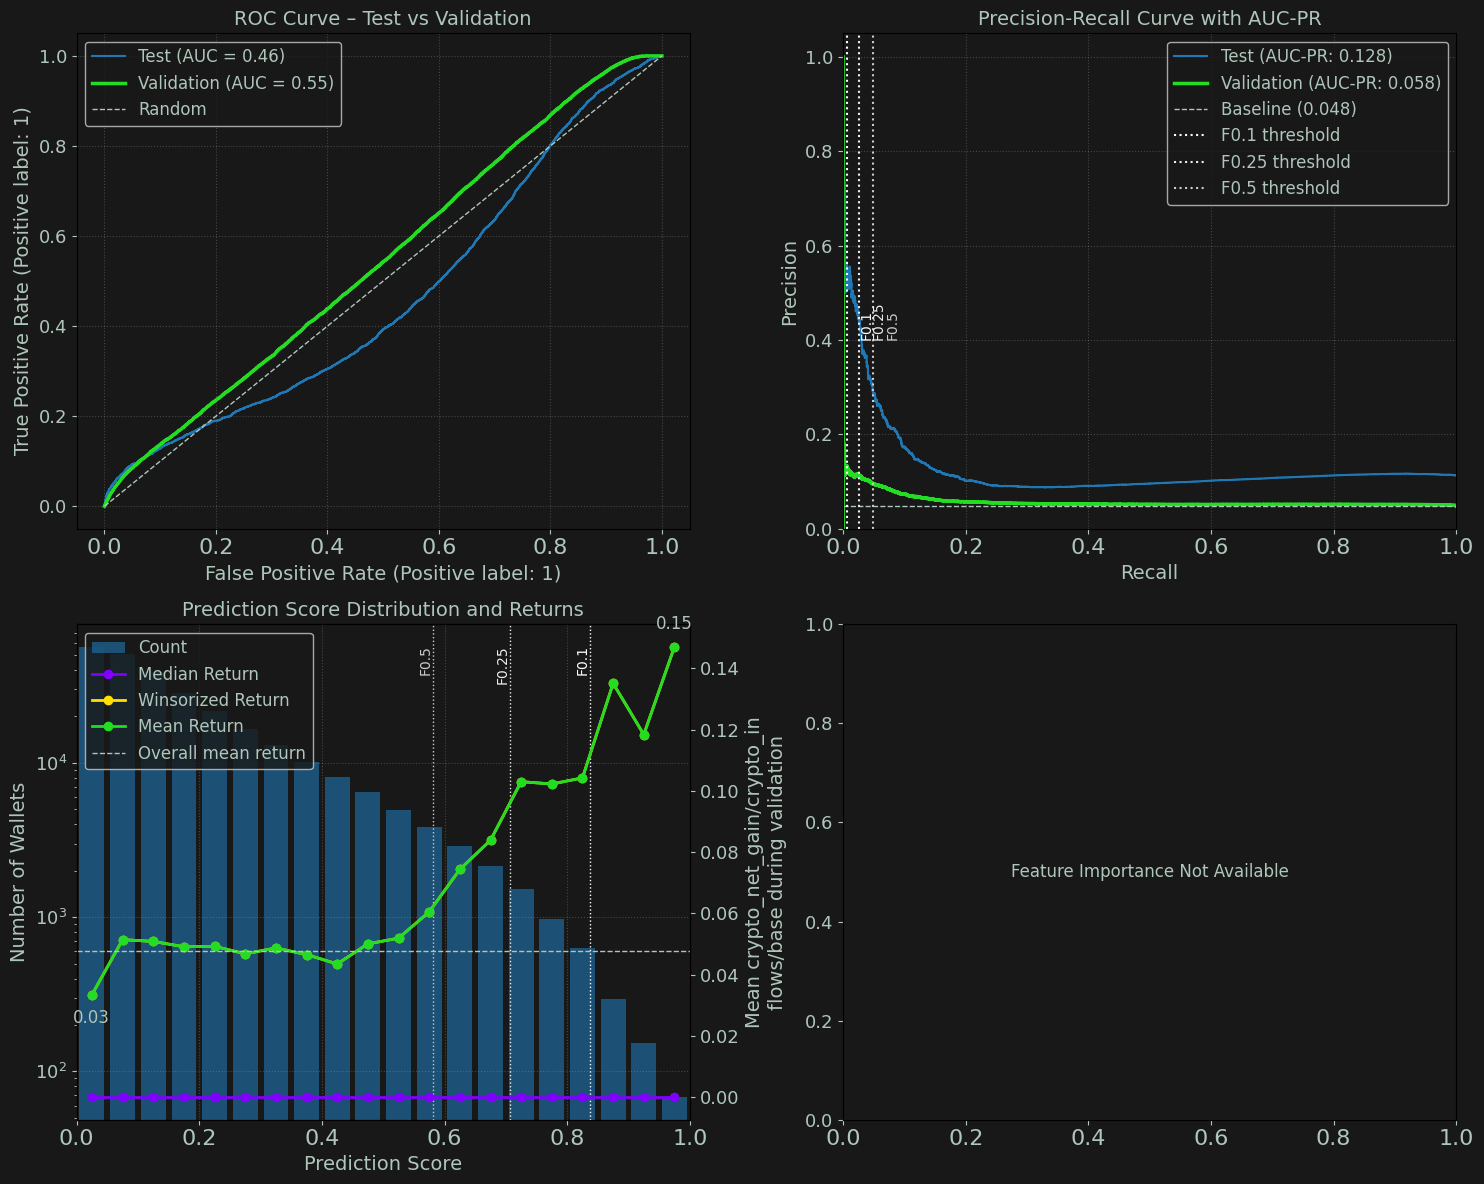

In [77]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


[06/Aug/25 20:14:10] INFO [615648764.<module>:2] s3://wallet-script-models/model-outputs/dda-945-filt-bal-s/concat/wscr-dda-945--concat-0806-200203/output/model.tar.gz
[06/Aug/25 20:14:10] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: crypto_net_gain/crypto_inflows/base  to 
ID: s3://wallet-script-models/model-outputs/dda-945-filt-bal-s/concat/wscr-dda-945--concat-0806-200203/output/model.tar.gz
Test Samples:             41,620
Val Positive Samples:     12,782 (4.8%)
Number of Features:       230

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.546  |  0.539
Val Accuracy:               0.949  |  0.888
Val Precision:              0.117  |  0.658
Val Recall:                 0.010  |  0.028
Val F1 Score:               0.019  |  0.054

Validation Returns    | Cutoff |  Mean   |  W-Mean
--------------------------------------------------
Overall Average       |    n

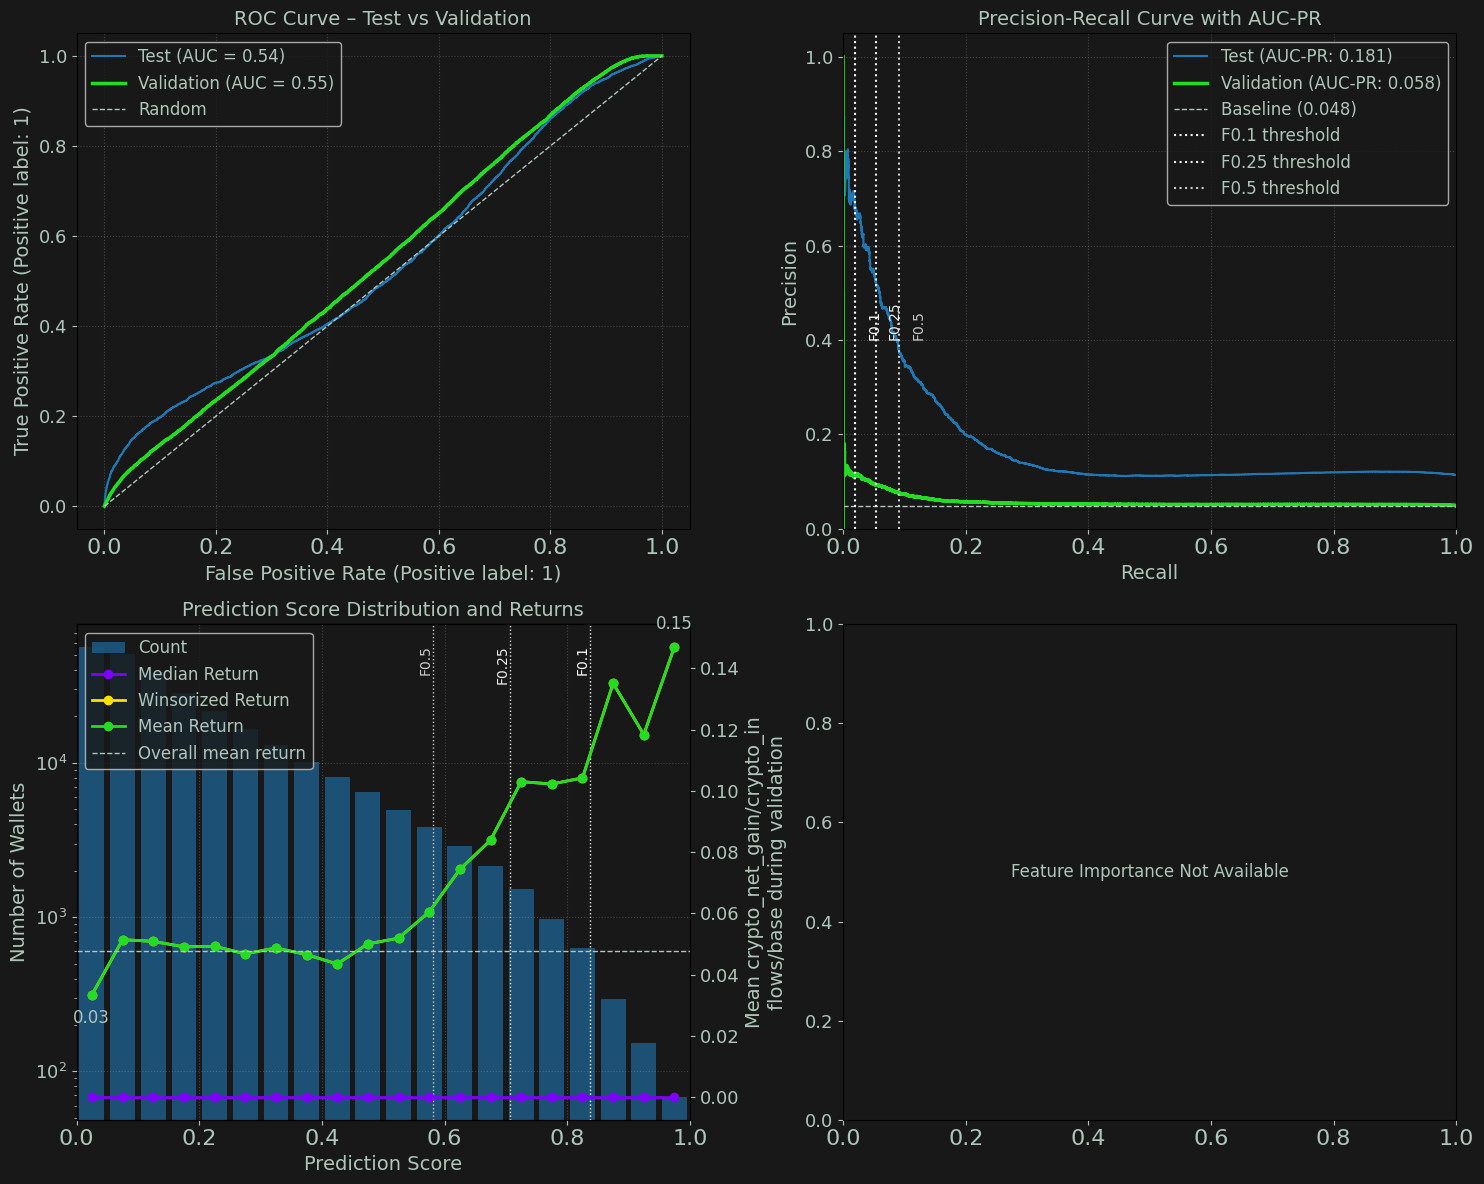

In [58]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


[06/Aug/25 13:51:03] INFO [3054640604.<module>:2] s3://wallet-script-models/model-outputs/dda-945-filters-bal/concat/wscr-dda-945--concat-0806-133703/output/model.tar.gz
[06/Aug/25 13:51:03] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: crypto_net_gain/crypto_inflows/base  to 
ID: sagemaker_concat_dda_945_filters_bal
Test Samples:             99,891
Val Positive Samples:     7,185 (5.5%)
Number of Features:       228

Test Set Classification Metrics
True Positives:             9258/99891 (9.3%)
-----------------------------------
ROC AUC:                    0.766
Log Loss:                   0.287
Accuracy:                   0.922
Precision:                  0.736
Recall:                     0.254
F1 Score:                   0.378



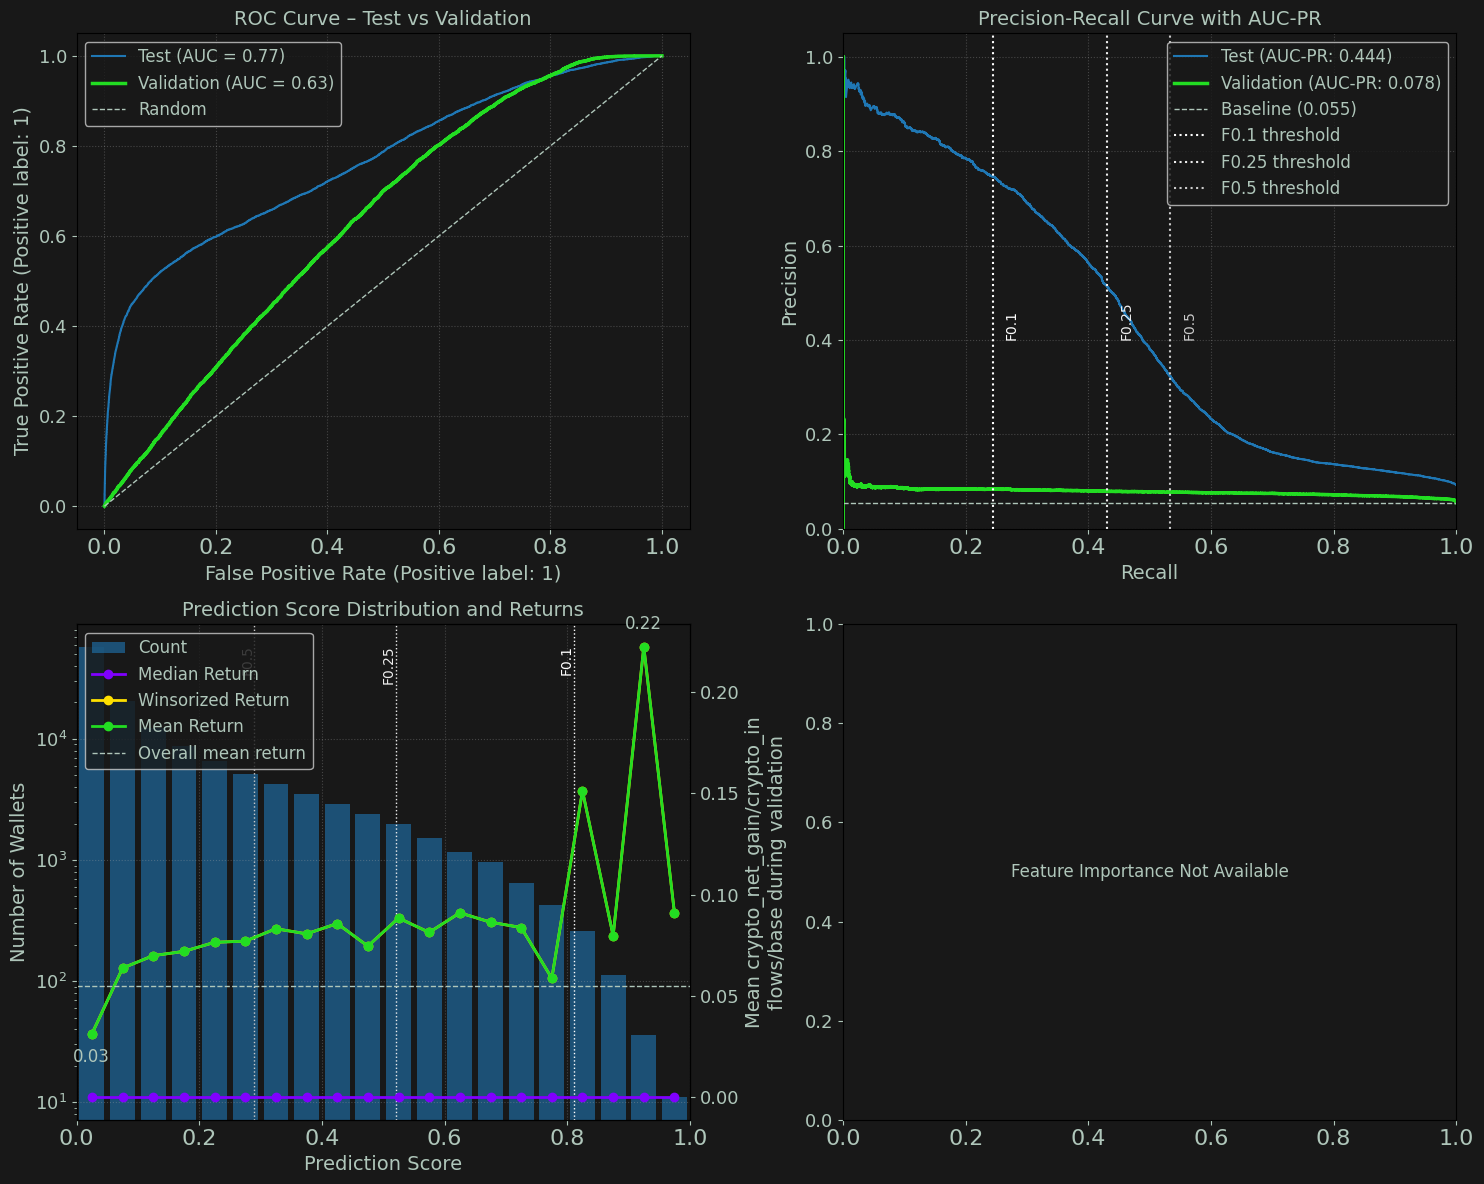

In [ ]:
# auc pr 0.4 mktcap 20M-4B
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


[06/Aug/25 00:38:03] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: crypto_net_gain/crypto_inflows/base  to 
ID: sagemaker_concat_dda_940_export_targets
Test Samples:             99,891
Val Positive Samples:     11,786 (9.0%)
Number of Features:       224

Test Set Classification Metrics
True Positives:             12750/99891 (12.8%)
-----------------------------------
ROC AUC:                    0.734
Log Loss:                   0.382
Accuracy:                   0.892
Precision:                  0.691
Recall:                     0.271
F1 Score:                   0.389



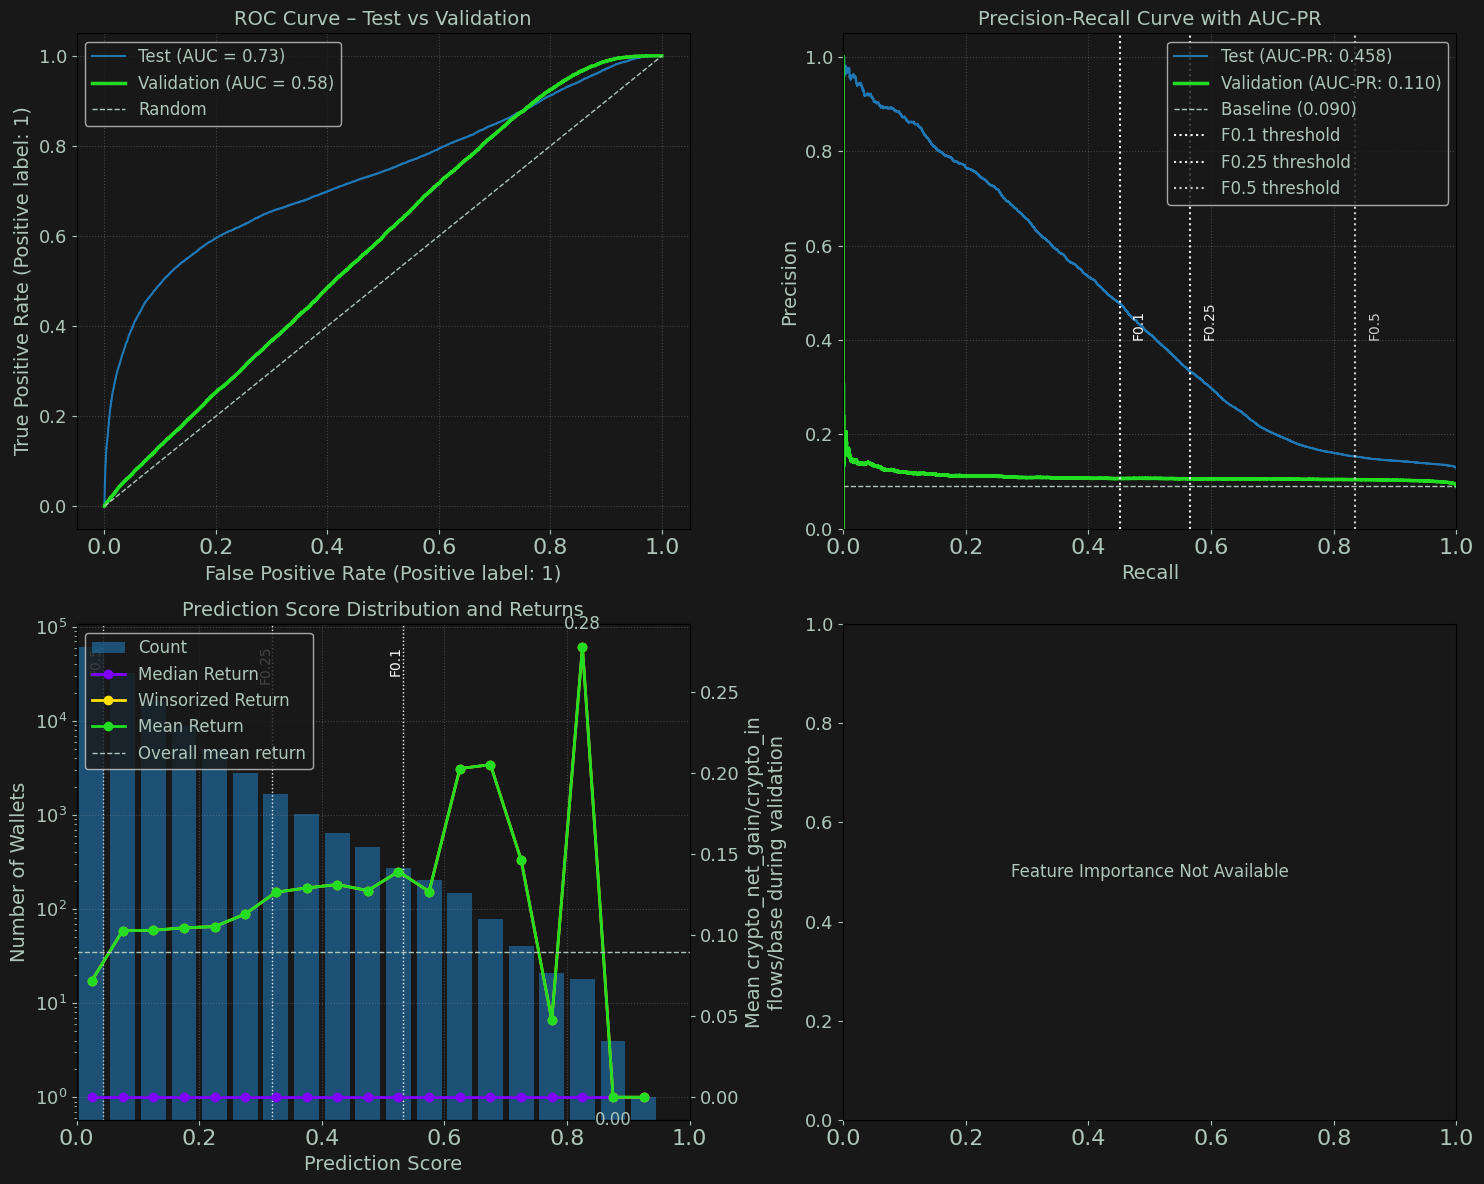

In [65]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


[06/Aug/25 00:24:03] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: crypto_net_gain/crypto_inflows/base  to 
ID: sagemaker_concat_dda_940_export_targets
Test Samples:             99,891
Val Positive Samples:     11,786 (9.0%)
Number of Features:       224

Test Set Classification Metrics
True Positives:             12750/99891 (12.8%)
-----------------------------------
ROC AUC:                    0.826
Log Loss:                   0.336
Accuracy:                   0.893
Precision:                  0.713
Recall:                     0.266
F1 Score:                   0.387



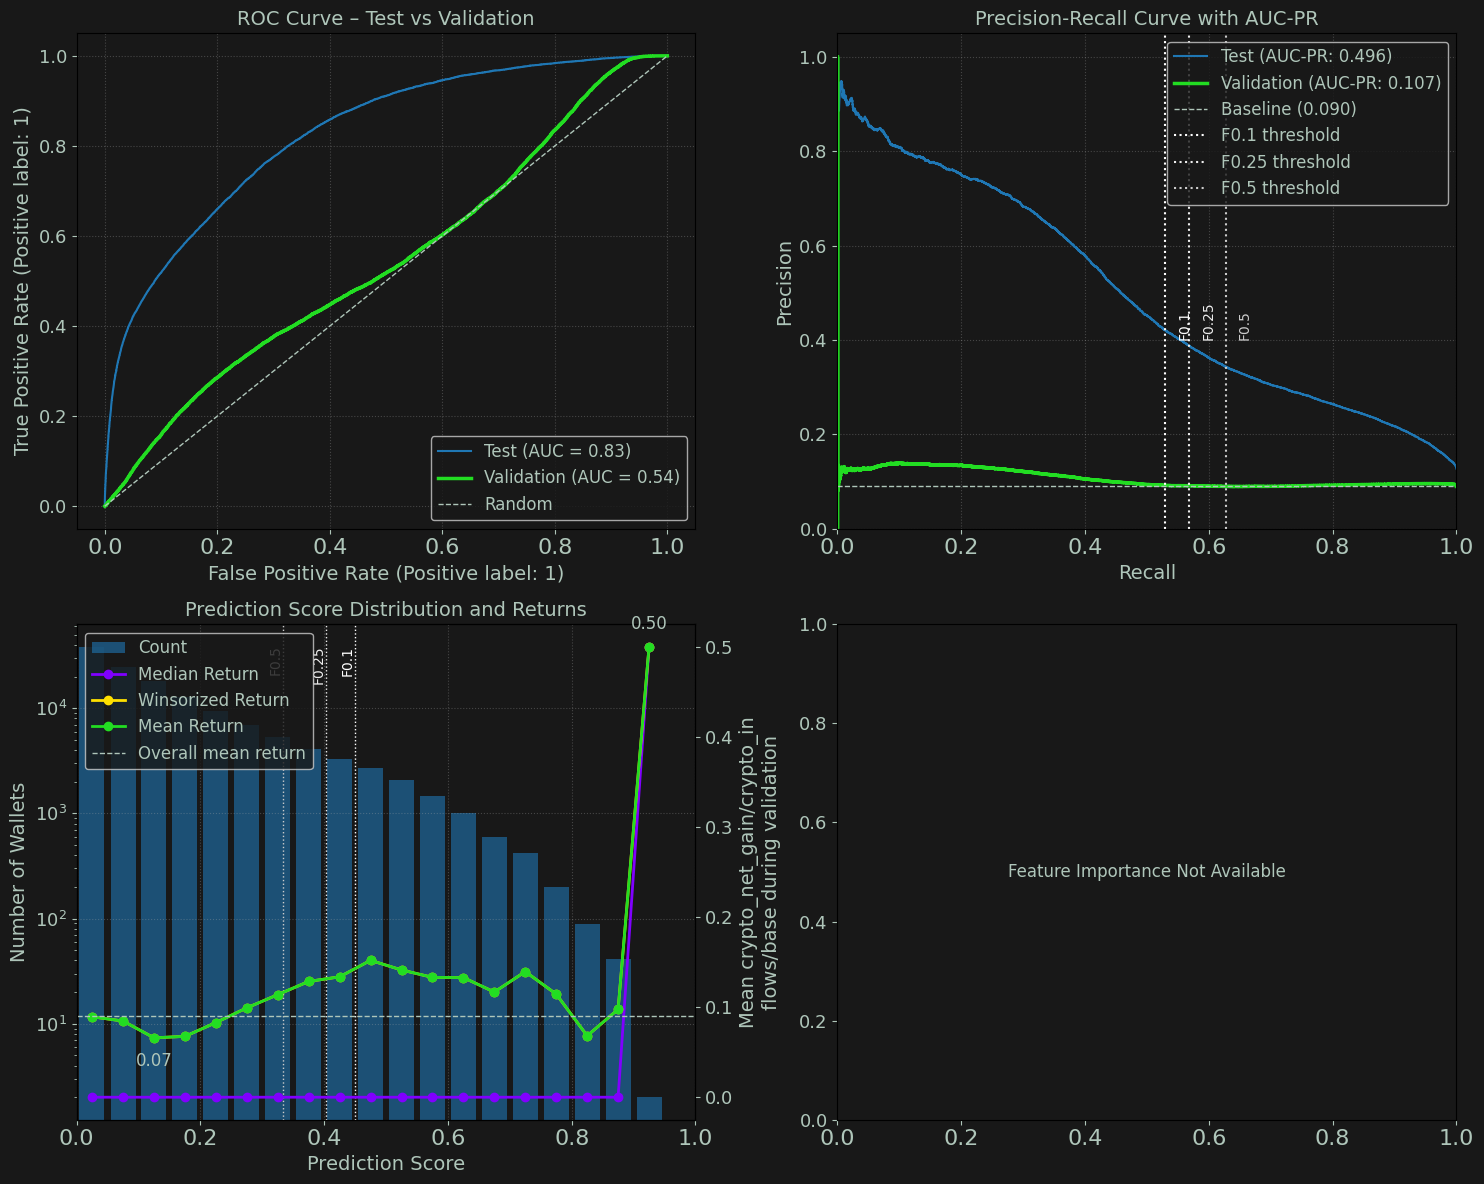

In [59]:
# auc pr mktcap 20M-4B, inflows $5k
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


[06/Aug/25 00:13:12] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: crypto_net_gain/crypto_inflows/base  to 
ID: sagemaker_concat_dda_940_export_targets
Test Samples:             99,891
Val Positive Samples:     11,786 (9.0%)
Number of Features:       224

Test Set Classification Metrics
True Positives:             12750/99891 (12.8%)
-----------------------------------
ROC AUC:                    0.734
Log Loss:                   0.382
Accuracy:                   0.892
Precision:                  0.691
Recall:                     0.271
F1 Score:                   0.389



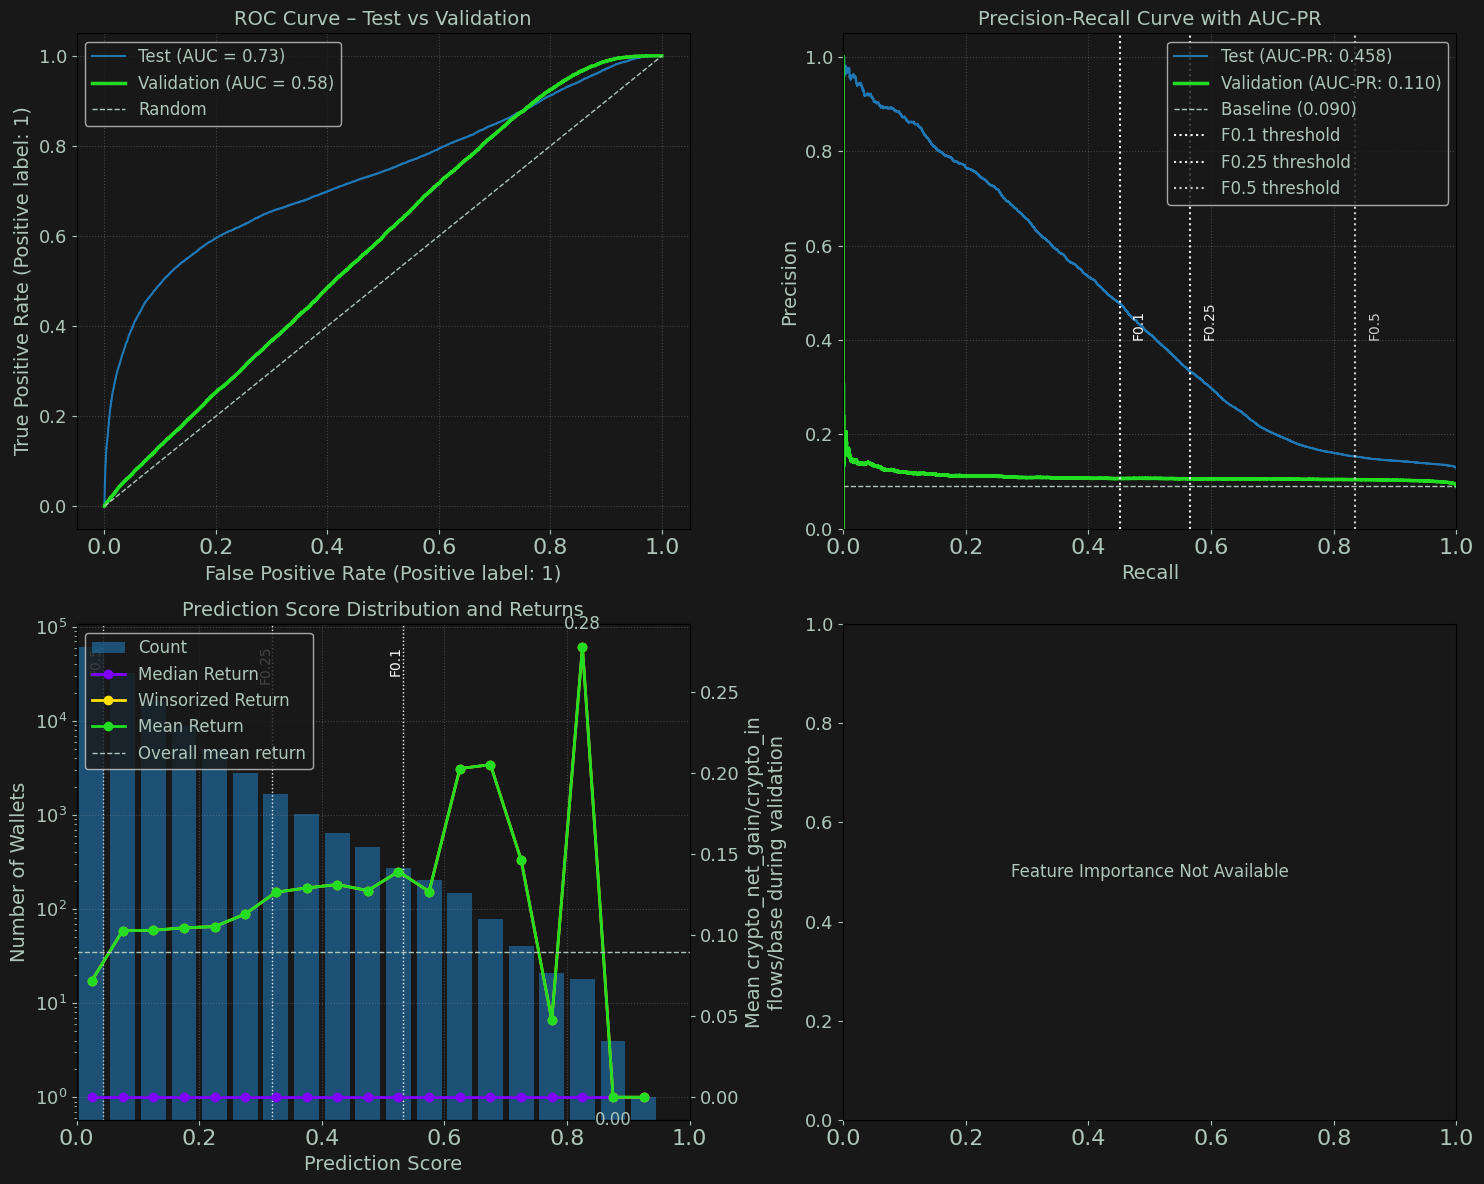

In [52]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


## Temporal cv model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))


date_suffixes = [
    '231008',
    '231107',
    '240306',
    '241101',
    '250301'
]
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
workflow_orch.load_all_training_data(date_suffixes)
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)

In [ ]:
sm.train_temporal_cv_script_model(sage_wallets_config,sage_wallets_modeling_config,cv_s3_uri)

## Single Model Sequence

### Train Single Model

#### retrieve file uris

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))

workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)



date_suffixes = [
    '231008',
    '231107',
    '240306',
    '250301'
]

# Generate URIs for specific dates without any prior setup
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)
s3_uris

#### train model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))

date_suffix = '231008'

modeler = wm.WalletModeler(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    s3_uris
)



In [ ]:
modeling_results = modeler.train_model()

### Score validation set

#### get existing model uri

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))



date_suffix = '231008'

# Generate URIs for specific dates without any prior setup
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris([date_suffix])

# Launch modeler
modeler = wm.WalletModeler(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    s3_uris
)


model_metadata = modeler.load_existing_model()

#### predict with batch transform

In [ ]:
transform_results = modeler.predict_with_batch_transform('val')

In [ ]:
transform_results = modeler.predict_with_batch_transform('test')

### Predict Using Endpoints

#### deploy endpoint for predictions

In [ ]:
modeler.list_active_endpoints()

In [ ]:
modeler.deploy_endpoint()

#### load and preprocess test/val dfs

In [ ]:
x_test = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_test_{date_suffix}.parquet"
)
x_val = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_val_{date_suffix}.parquet"
)




In [ ]:
preprocessor = SageWalletsPreprocessor(sage_wallets_config)
x_test_processed = preprocessor.preprocess_x_df(x_test)
x_val_processed = preprocessor.preprocess_x_df(x_val)

logger.info(f"Preprocessed X_test {x_test_processed.shape} and "
            f"X_val {x_val_processed.shape}.")

#### predict

In [ ]:
y_test_pred = modeler.predict_using_endpoint(x_test_processed, 'test')
y_val_pred = modeler.predict_using_endpoint(x_val_processed, 'val')

#### delete all endpoints

In [ ]:
modeler.delete_all_endpoints()

In [ ]:
modeler.list_active_endpoints()
modeler.list_all_endpoints()

## Script model training

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))


date_suffixes = [
    '231008',
    '231107',
    '240306',
    '250301'
]

date_suffix = '231008'


workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
workflow_orch.load_all_training_data(date_suffixes)
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))

date_suffix = '231008'

modeler = wm.WalletModeler(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    s3_uris
)



In [ ]:
sm.train_single_period_script_model(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    s3_uris
)

In [ ]:
from sagemaker.session import Session
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter

s3_data = {
    "train":      s3_uris[date_suffix]['train'],
    "validation": s3_uris[date_suffix]['val']
}
model_output_path = (f"s3://wallet-script-models/model-outputs")

estimator = XGBoost(
    entry_point         = "script_mode_modeler.py",     # path relative to notebook
    source_dir          = "../src/script_modeling/",    # folder that holds the script
    base_job_name       = "dda-922-v4",                 # uploaded and immutable script version
    framework_version   = sage_wallets_modeling_config['framework']['version'],
    role                = sage_wallets_config['aws']['modeler_arn'],
    instance_type       = sage_wallets_modeling_config['metaparams']['instance_type'],
    instance_count      = sage_wallets_modeling_config['metaparams']['instance_count'],
    output_path         = model_output_path,
    hyperparameters = {
        "eta": 0.1,
        "max_depth": 6,
        "subsample": 1.0,
        "num_boost_round": 50,            # small for a smoke-test
        "early_stopping_rounds": 10
    },
    # metric_definitions=[                  # regex must match the print line
    #     {"Name": "cv_auc_pr", "Regex": "validation:cv_auc_pr=(.*)"}
    # ],
)

# one-shot fit (no tuning yet)
estimator.fit(s3_data, logs="All")

# Model Evaluation

### Analyze predictions

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))


date_suffixes = [
    '231008',
    # '240306'
]
date_suffix = date_suffixes[0]

In [ ]:
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_val_pred = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)

In [ ]:
# Single function call for complete evaluation
evaluator = sime.run_sagemaker_evaluation(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    y_test_pred,
    y_val_pred
)

In [ ]:
evaluator.y_validation

In [ ]:
evaluator.y_validation_pred_proba

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(evaluator.y_validation, evaluator.y_validation_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()


In [ ]:
def load_sagemaker_predictions(
    data_type: str,
    sage_wallets_config: dict,
    sage_wallets_modeling_config: dict,
    date_suffix: str
) -> tuple[pd.Series, pd.Series]:
    """
    Load SageMaker predictions and corresponding actuals for a given data type.

    Params:
    - data_type (str): Either 'test' or 'val'
    - sage_wallets_config (dict): Configuration for training data paths
    - sage_wallets_modeling_config (dict): Configuration for model parameters
    - date_suffix (str): Date suffix for file naming

    Returns:
    - tuple: (predictions_series, actuals_series) with aligned indices
    """
    # Load predictions
    pred_path = Path(sage_wallets_modeling_config['metaparams']['endpoint_preds_dir']) / \
                f"endpoint_y_pred_{data_type}_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}.csv"
    pred_df = pd.read_csv(pred_path)

    if 'score' not in pred_df.columns:
        raise ValueError(f"SageMaker predictions are missing the 'score' column. "
                        f"Available columns: {pred_df.columns}")
    pred_series = pred_df['score']

    # Load actuals
    training_data_path = (
        Path(f"../s3_uploads") / "wallet_training_data_queue" /
        f"{sage_wallets_config['training_data']['local_directory']}"
    )
    actuals_path = training_data_path / f"y_{data_type}_{date_suffix}.parquet"
    actuals_df = pd.read_parquet(actuals_path)

    if len(actuals_df.columns) > 1:
        raise ValueError(f"Found unexpected columns in y_{data_type}_df. "
                        f"Expected 1 column, found {actuals_df.columns}.")
    actuals_series = actuals_df.iloc[:, 0]

    # Validate lengths and align indices
    if len(pred_series) != len(actuals_series):
        raise ValueError(f"Length of y_{data_type}_pred ({len(pred_series)}) does "
                        f"not match length of y_{data_type}_true ({len(actuals_series)}).")

    pred_series.index = actuals_series.index

    return pred_series, actuals_series

In [ ]:
# Load predictions and actuals
y_test_pred_series, y_test_true_series = load_sagemaker_predictions(
    'test', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)
y_val_pred_series, y_val_true_series = load_sagemaker_predictions(
    'val', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)

# Load remaining training data
training_data_path = (
    Path(f"../s3_uploads") / "wallet_training_data_queue" /
    f"{sage_wallets_config['training_data']['local_directory']}"
)
X_train = pd.read_parquet(training_data_path / f"x_train_{date_suffix}.parquet")
y_train = pd.read_parquet(training_data_path / f"y_train_{date_suffix}.parquet")
X_test = pd.read_parquet(training_data_path / f"x_test_{date_suffix}.parquet")
X_val = pd.read_parquet(training_data_path / f"x_val_{date_suffix}.parquet")

# Identify target variable and model type
target_variable = y_val_true_series.name or y_train.columns[0]
objective = sage_wallets_modeling_config['training']['hyperparameters']['objective']
model_type = 'regression' if objective[:3] == 'reg' else 'unknown'

In [ ]:
# Create model_id and modeling_config
model_id = f"sagemaker_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}"

modeling_config = {
    'target_variable': target_variable,
    'model_type': model_type,
    'returns_winsorization': 0.005,  # Default for winsorizing returns
    'training_data': {
        'modeling_period_duration': 30  # Default performance window
    },
    'sagemaker_metadata': {
        'objective': objective,
        'local_directory': sage_wallets_config['training_data']['local_directory'],
        'date_suffix': date_suffix
    }
}

# Create minimal wallet_model_results for SageMaker evaluation
wallet_model_results = {
    'model_id': model_id,
    'modeling_config': modeling_config,
    'model_type': model_type,

    # Training data
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test_true_series,
    'y_pred': y_test_pred_series,
    'training_cohort_pred': None,
    'training_cohort_actuals': None,

    # Validation data
    'X_validation': X_val,
    'y_validation': y_val_true_series,
    'y_validation_pred': y_val_pred_series,
    'validation_target_vars_df': None,

    # Fixed mock pipeline
    'pipeline': type('MockPipeline', (), {
        'named_steps': {'estimator': type('MockModel', (), {
            'get_params': lambda self: {'objective': objective}  # Accept self argument
        })()},
        '__getitem__': lambda self, key: type('MockTransformer', (), {
            'transform': lambda self, X: X  # Accept self argument
        })()
    })()
}

# Create evaluator
wallet_evaluator = wime.RegressorEvaluator(wallet_model_results)

# Run basic evaluation
wallet_evaluator.summary_report()
wallet_evaluator.plot_wallet_evaluation()

In [ ]:
target_variable